In [94]:
import pandas as pd

from torchvision.io import read_image

import matplotlib.pyplot as plt

In [122]:
def plot_sample_data(sample, slide=80):
    
    kps_i = np.zeros(sample['scan_i'][:, :, slide].shape)
    kps_e = np.zeros(sample['scan_e'][:, :, slide].shape)
    
    for kp in sample['kps_i'][sample['kps_i'][:, 2] == slide]:
        kps_i[int(kp[1]), int(kp[0])] = 1
    for kp in sample['kps_e'][sample['kps_e'][:, 2] == slide]:
        kps_e[int(kp[1]), int(kp[0])] = 1
    
    
    fig, axs = plt.subplots(3,2, figsize=(10,10))
    axs[0,0].imshow(sample['scan_i'][:, :, slide], cmap='gray')
    axs[0,1].imshow(sample['scan_e'][:,:, slide], cmap='gray')
    axs[1,0].imshow(sample['mask_i'][:,:, slide], cmap='gray')
    axs[1,1].imshow(sample['mask_e'][:,:, slide], cmap='gray')
    axs[2,0].imshow(kps_i, cmap='gray')
    axs[2,1].imshow(kps_e, cmap='gray')
    axs[0, 0].axis('off')
    axs[0, 1].axis('off')
    axs[1, 0].axis('off')
    axs[1, 1].axis('off')
    axs[2, 0].axis('off')
    axs[2, 1].axis('off')
    plt.tight_layout()
    plt.show()

In [129]:
import numpy as np
import torch
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
from typing import List

import nibabel as nib
import csv


# TODO: Add MIND images/features???
# TODO: specific data preprocessing for different datasets 

class LungDatasets(Dataset):
    def __init__(self, sources, root_dir:Path,
                 partitions: List[str] = ['train', 'val'],
                 transform=None):
        self.sources = sources
        self.root_dir = root_dir
        self.partitions = partitions
        self.transform = transform
        
        
        self.get_image_paths()

    def __len__(self):
        total_images = 0
        for part in self.partitions:
            for source in self.sources:
                split_path = self.root_dir/f'{source}/{part}_cases.txt'
                if not split_path.exists():
                    raise ValueError(f'Partition {part} not found for {source} in {self.root_dir}')
                with open(split_path, 'r') as f:
                    cases = f.readlines()
                    total_images += len(cases)
        return total_images
    
    
    def __getitem__(self, idx):
        
        # retrieve some metadata
        sample = {'idx':idx}
        dataset = self.image_paths['scan_i'][idx].parent.parent.name
        case =  self.image_paths['scan_i'][idx].name[:8]
        sample['dataset'] = dataset
        sample['case'] = case
        
        
        if dataset == 'learn2reg':
            # load images
            sample['scan_i'] = torch.from_numpy(nib.load(self.image_paths['scan_i'][idx]).get_fdata()).float()
            sample['scan_e'] = torch.from_numpy(nib.load(self.image_paths['scan_e'][idx]).get_fdata()).float()
            sample['mask_i'] = torch.from_numpy(nib.load(self.image_paths['mask_i'][idx]).get_fdata()).float()
            sample['mask_e'] = torch.from_numpy(nib.load(self.image_paths['mask_e'][idx]).get_fdata()).float()
            
            # load keypoints
            corrfield = torch.empty(0,6)
            with open(self.image_paths['kps'][idx], newline='') as csvfile:
                fread = csv.reader(csvfile, delimiter=',', quotechar='|')
                for row in fread:
                    corrfield = torch.cat((corrfield,torch.from_numpy(np.array(row).astype('float32')).float().view(1,6)),0)
            
        
        # NOT SURE ABOUT WHY RESCALE
        # sample['keypts_fix'] = torch.stack((corrfield[:,2+0]/207*2-1,corrfield[:,1+0]/191*2-1,corrfield[:,0+0]/191*2-1),1)
        # sample['keypts_mov'] = torch.stack((corrfield[:,2+3]/207*2-1,corrfield[:,1+3]/191*2-1,corrfield[:,0+3]/191*2-1),1)        

        
        # keypoints format same across dataset so just reorder
        sample['kps_e'] = torch.stack((corrfield[:,2],
                                       corrfield[:,1],
                                       corrfield[:,0]),1)
        
        sample['kps_i'] = torch.stack((corrfield[:,5],
                                       corrfield[:,3],
                                       corrfield[:,3]),1)     
        
        return sample
    
    
    def get_image_paths(self):
        self.image_paths = {'scan_i':[], 'scan_e':[],
                            'mask_i':[], 'mask_e':[],
                            'kps':[]}
        
        for part in self.partitions:
            for source in self.sources:
                split_path = self.root_dir/f'{source}/{part}_cases.txt'
                
                if not split_path.exists():
                    raise ValueError(f'Partition {part} not found for {source} in {self.root_dir}')
                
                with open(split_path, 'r') as f:
                    
                    cases = [x.strip() for x in f.readlines()]
                    
                    for case in cases:
                        self.image_paths['scan_i'].append(self.root_dir/f'{source}/scans/{case}_insp.nii.gz')
                        self.image_paths['scan_e'].append(self.root_dir/f'{source}/scans/{case}_exp.nii.gz')
                        self.image_paths['mask_i'].append(self.root_dir/f'{source}/lungMasks/{case}_insp.nii.gz')
                        self.image_paths['mask_e'].append(self.root_dir/f'{source}/lungMasks/{case}_exp.nii.gz')
                        self.image_paths['kps'].append(self.root_dir/f'{source}/keypoints/{case}.csv')
        
        # check that all paths exist
        for k in self.image_paths.keys():
            for p in self.image_paths[k]:
                try:
                    assert p.exists()
                except AssertionError:
                    raise ValueError(f'Path {p} does not exist')

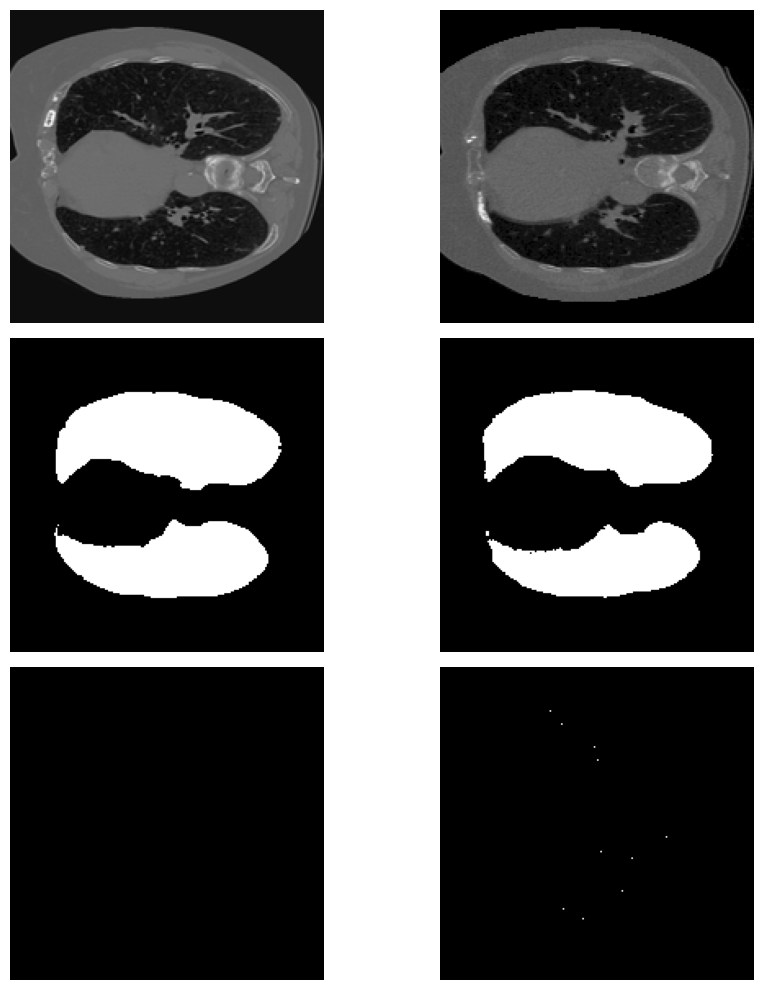

In [130]:
l2r = LungDatasets(sources=['learn2reg'], root_dir=Path('data'),partitions=['train'])
s = l2r[1]
# s['keypts_mov']
# s['case']
plot_sample_data(s)

In [132]:
s['kps_i']

tensor([[ 54.5590,  30.3110,  30.3110],
        [ 73.1520,  32.9310,  32.9310],
        [ 75.9100,  33.0080,  33.0080],
        ...,
        [112.5980, 157.9930, 157.9930],
        [ 98.8580, 157.9600, 157.9600],
        [114.9000, 158.0090, 158.0090]])

In [133]:
s['kps_e']

tensor([[ 53.,  71.,  31.],
        [ 72.,  77.,  32.],
        [ 75.,  83.,  32.],
        ...,
        [113.,  97., 158.],
        [ 97.,  99., 158.],
        [115., 100., 158.]])